In [ ]:

# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torchvision.models.resnet import ResNet
from torchvision.models.resnet import BasicBlock
from torch.optim import Adam

import cv2


In [ ]:
! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
#! kaggle competitions download -c histopathologic-cancer-detection

In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:

! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [02:12<00:00, 112MB/s] 
100% 6.31G/6.31G [02:12<00:00, 51.0MB/s]


In [ ]:
! unzip /content/histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [ ]:
import os
labels = pd.read_csv('train_labels.csv')
print(f'{len(os.listdir("./train"))} pictures in train.')
print(f'{len(os.listdir("./test"))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


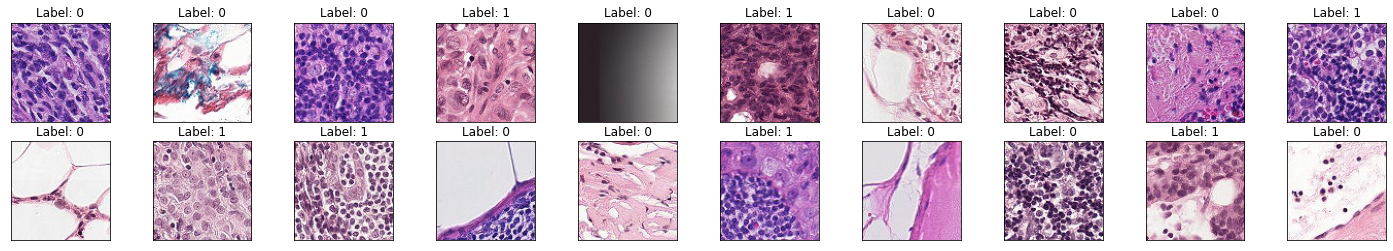

In [ ]:


fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("./train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./train/" + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [ ]:

labels.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [ ]:
# from scratch -- we're just extracting the 32x32 patches at the moment
data_transforms = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
data_transforms_test = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
# indices for validation
tr, val = train_test_split(labels.label, stratify=labels.label, test_size=0.1)


In [ ]:
# dictionary with labels and ids of train data
img_class_dict = {k:v for k, v in zip(labels.id, labels.label)}

class CancerDataset(Dataset):
    def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dict[img_name_short]
        else:
            label = 0
        return image, label

In [ ]:
%%time
# Load train data 
dataset = CancerDataset(datafolder='./train', datatype='train', transform=data_transforms, labels_dict=img_class_dict)

CPU times: user 313 ms, sys: 166 ms, total: 480 ms
Wall time: 639 ms


In [ ]:
# get labels in correct order.
ims = pd.DataFrame(dataset.image_files_list, columns=['img'])
ims['img'] = ims['img'].apply(lambda x: x.split('.')[0])
joined = ims.join(labels)
lbs = joined.label.values
dataset.labels = lbs

In [ ]:
test_set = CancerDataset(datafolder='./test', datatype='test', transform=data_transforms_test)

In [ ]:
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 512
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.2)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.sig(self.fc3(x))
        return x

In [ ]:
model_conv = Net()
model_conv.cuda()
criterion = nn.BCELoss()

optimizer = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
valid_loss_min = np.Inf
patience = 7
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 10
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    exp_lr_scheduler.step()
    train_auc = []

    for batch_i, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output[:,1], target.float())
        train_loss.append(loss.item())
        
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(a, b))

        loss.backward()
        optimizer.step()
    
    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output[:,1], target.float())

        val_loss.append(loss.item()) 
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(a, b))

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid acc: {np.mean(val_auc):.4f}')
    
    valid_loss = np.mean(val_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_conv.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

Sat Apr 23 23:36:30 2022 Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1, train loss: 0.6785, valid loss: 0.6694, train auc: 0.6383, valid acc: 0.6943
Validation loss decreased (inf --> 0.669376).  Saving model ...
Sat Apr 23 23:43:25 2022 Epoch: 2
Epoch 2, train loss: 0.6664, valid loss: 0.6608, train auc: 0.7076, valid acc: 0.7214
Validation loss decreased (0.669376 --> 0.660814).  Saving model ...
Sat Apr 23 23:49:07 2022 Epoch: 3
Epoch 3, train loss: 0.6503, valid loss: 0.6311, train auc: 0.7492, valid acc: 0.7760
Validation loss decreased (0.660814 --> 0.631130).  Saving model ...
Sat Apr 23 23:54:19 2022 Epoch: 4
Epoch 4, train loss: 0.5935, valid loss: 0.5601, train auc: 0.7947, valid acc: 0.7972
Validation loss decreased (0.631130 --> 0.560106).  Saving model ...
Sat Apr 23 23:59:18 2022 Epoch: 5
Epoch 5, train loss: 0.5565, valid loss: 0.5557, train auc: 0.8010, valid acc: 0.7977
Validation loss decreased (0.560106 --> 0.555687).  Saving model ...
Sun Apr 24 00:04:14 2022 Epoch: 6
Epoch 6, train loss: 0.5524, valid loss: 0.5519, train auc: 

In [ ]:
# all pretrained nets from torch require at least 224x224
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-08a8d7d8-9451-e22e-a089-b1f389ee161f)


In [ ]:
class CancerDataset(Dataset):
    def __init__(self, datafolder, datatype='train', transform = transforms.Compose([transforms.CenterCrop(32),transforms.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.datatype = datatype
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        if self.datatype == 'train':
            self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        else:
            self.labels = [0 for _ in range(len(self.image_files_list))]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        if self.datatype == 'train':
            label = self.labels_dict[img_name_short]
        else:
            label = 0
        return image, label

In [ ]:
import albumentations
from albumentations import torch as AT
# import pretrainedmodels

In [ ]:
data_transforms = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

dataset = CancerDataset(datafolder='./train/', datatype='train', transform=data_transforms, labels_dict=img_class_dict)
test_set = CancerDataset(datafolder='./test/', datatype='test', transform=data_transforms_test)
train_sampler = SubsetRandomSampler(list(tr.index))
valid_sampler = SubsetRandomSampler(list(val.index))
batch_size = 32
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)



In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for i, param in model_conv.named_parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 2)

In [ ]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
#scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
train_auc = []
val_auc = []

In [ ]:
valid_loss_min = np.Inf
patience = 5
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 5
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    # scheduler.step(epoch)
    train_auc = []

    for batch_i, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output[:,1], target.float())
        train_loss.append(loss.item())
        
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        train_auc.append(roc_auc_score(a, b))

        loss.backward()
        optimizer.step()
    
    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output[:,1], target.float())

        val_loss.append(loss.item()) 
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(a, b))

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
    #print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_conv.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

Sun Apr 24 00:59:31 2022 Epoch: 1
Epoch 1, train loss: 0.9346, valid loss: 0.6755.
Validation loss decreased (inf --> 0.675457).  Saving model ...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Sun Apr 24 01:43:16 2022 Epoch: 2
Epoch 2, train loss: 0.7851, valid loss: 0.7271.
1 epochs of increasing val loss
Sun Apr 24 02:24:49 2022 Epoch: 3


In [ ]:
# do the same thing with Alexnet -- bruh the training time tho

In [ ]:
import torch
model_conv = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_conv.eval()


In [ ]:
for i, param in model_conv.named_parameters():
    param.requires_grad = False

In [ ]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(2048, 2)

In [ ]:
model_conv.cuda()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.005, momentum=0.99)
#scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
valid_loss_min = np.Inf
patience = 5
# current number of epochs, where validation loss didn't increase
p = 0
# whether training should be stopped
stop = False

# number of epochs to train the model
n_epochs = 5
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    # scheduler.step(epoch)
    train_auc = []

    for batch_i, (data, target) in enumerate(train_loader):

        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output[:,1], target.float())
        train_loss.append(loss.item())
        
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # train_auc.append(roc_auc_score(a, b))

        loss.backward()
        optimizer.step()
    
    model_conv.eval()
    val_loss = []
    val_auc = []
    for batch_i, (data, target) in enumerate(valid_loader):
        data, target = data.cuda(), target.cuda()
        output = model_conv(data)

        loss = criterion(output[:,1], target.float())

        val_loss.append(loss.item()) 
        a = target.data.cpu().numpy()
        b = output[:,-1].detach().cpu().numpy()
        # val_auc.append(roc_auc_score(a, b))

    # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_conv.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        p = 0

    # check if validation loss didn't improve
    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break